In [1]:
!pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import numpy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10
from keras.layers import Add, Dense, Activation, BatchNormalization, Conv2D
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.utils import np_utils
from keras.initializers import glorot_uniform
%matplotlib inline

In [3]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EZjUnU2vtQBMgiE6VDtwCHsBCoEpSC5Q8mIwJjjGieEe1w?download=1 -O CelebA_HQ_face_gender_dataset_test.zip
!unzip CelebA_HQ_face_gender_dataset_test.zip -d ./CelebA_HQ_face_gender_dataset_test

--2022-11-20 07:40:06--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EZjUnU2vtQBMgiE6VDtwCHsBCoEpSC5Q8mIwJjjGieEe1w?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebA_HQ_face_gender_dataset_test.zip?ga=1 [following]
--2022-11-20 07:40:07--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebA_HQ_face_gender_dataset_test.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 619277922 (591M) [application/x-zip-compressed]
Saving to: ‘CelebA_HQ_face_gender_dataset_test.zip’

100%[======================================>] 619,277,922 54.9

In [4]:
img_height = 64
img_width = 64
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = './CelebA_HQ_face_gender_dataset_test',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size= 6001 )

Found 6001 files belonging to 2 classes.
Using 4801 files for training.


In [5]:
class_names = train_ds.class_names
print(class_names)

['female', 'male']


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory = './CelebA_HQ_face_gender_dataset_test',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size= 6001 )

Found 6001 files belonging to 2 classes.
Using 1200 files for validation.


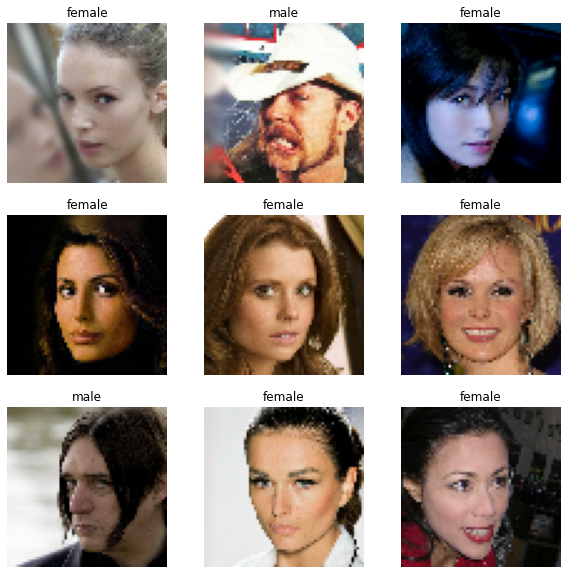

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
X_train, y_train = next(iter(normalized_ds))

normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
X_test, y_test = next(iter(normalized_ds))


print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

(4801,) (1200,)
(4801, 64, 64, 3) (1200, 64, 64, 3)


In [10]:
model_type = 'vgg16'

In [11]:
model_home_dir = os.path.join(os.getcwd(), 'CNN_TASK_ODED',"model_type")
print(model_home_dir)
if not os.path.isdir(model_home_dir):
    print('Inside mkdir')
    os.makedirs(model_home_dir)

/home/ec2-user/SageMaker/Research/AWS/CNN_TASK_ODED/model_type


In [12]:
#Defining Variables

#Data set information
DATASET = 'CelebA_HQ'
num_classes = 2
input_shape=( 64, 64,3)
epochs = 200
lrate = 0.01
decay = lrate/epochs
batch_size = 32
seed = 7
np.random.seed(seed)

validate_dir = os.path.join("data","test")
train_dir = os.path.join("data","train")

# Prepare model model saving directory.
save_dir = os.path.join(model_home_dir, 'saved_models')

model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print("Model Type: ",model_type)
print("Model File: ",filepath)

Model Type:  vgg16
Model File:  /home/ec2-user/SageMaker/Research/AWS/CNN_TASK_ODED/model_type/saved_models/CelebA_HQ_vgg16_model.{epoch:03d}.h5


In [13]:
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')


X_train_mean = np.mean(X_train)
X_train -= X_train_mean
X_test_mean = np.mean(X_test)
X_test -= X_test_mean

y_train = np_utils.to_categorical(y_train,)
y_test = np_utils.to_categorical(y_test,)
y_train = np.delete(y_train,1,1)
y_test = np.delete(y_test,1,1)
print(y_train.shape, y_test.shape)



(4801, 1) (1200, 1)


In [14]:
from tensorflow.keras.layers import Dropout
def vgg16(input_shape=(32,32,3), num_classes=2):
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


  model.add(Dropout(0.8))

  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))

  return model

In [15]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [16]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]


In [17]:
 model = vgg16(input_shape,num_classes)

# Compile model

# optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss= 'binary_crossentropy' , optimizer=optimizer, metrics=['accuracy'])
print("Model Summary of ",model_type)
print(model.summary())



Model Summary of  vgg16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        9232      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        2320      
                                

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
# Score trained model.
history = model.fit(X_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(X_test, y_test),
      shuffle=True,
      callbacks=callbacks)
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
Epoch 1/200
151/151 [==============================] - 108s 18ms/step - loss: 0.6121 - accuracy: 0.6622 - val_loss: 0.6103 - val_accuracy: 0.6975 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
151/151 [==============================] - 2s 11ms/step - loss: 0.5145 - accuracy: 0.7455 - val_loss: 0.5378 - val_accuracy: 0.7175 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
151/151 [==============================] - 1s 10ms/step - loss: 0.4801 - accuracy: 0.7769 - val_loss: 0.5112 - val_accuracy: 0.7583 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
151/151 [==============================] - 1s 10ms/step - loss: 0.4306 - accuracy: 0.8055 - val_loss: 0.4673 - val_accuracy: 0.7767 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
151/151 [==============================] - 1s 9ms/step - loss: 0.3821 - accuracy: 0.8309 - val_loss: 0.3956 - val_accuracy: 0.8042 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
151/151 [==============================] - 1s 9ms/step - loss: 0.3363 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


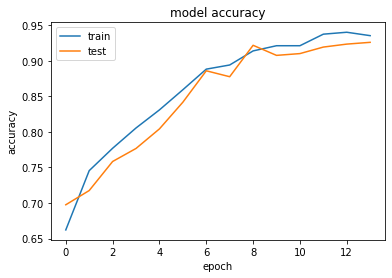

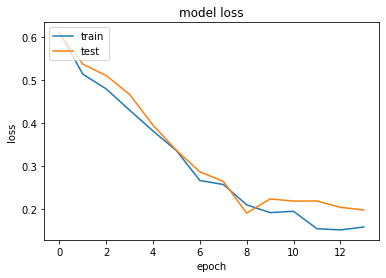

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

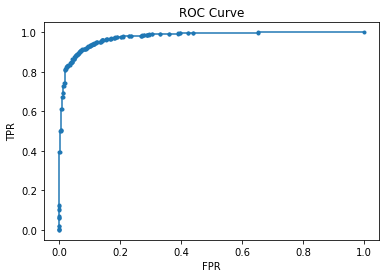

0.9762405028502531


In [20]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
plt.title('ROC Curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

print(auc_keras)

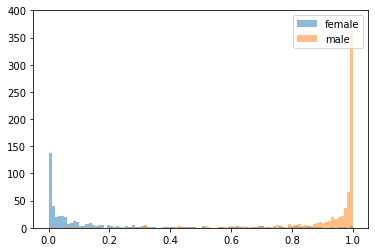

In [21]:
from matplotlib import pyplot
predict_x=model.predict(X_test) 

female_index = np.where(y_test.reshape(-1) == 0.)
female = predict_x[female_index]

male_index = np.where(y_test.reshape(-1) == 1.)
male = predict_x[male_index]



bins = np.linspace(0, 1, 100)

pyplot.hist(female, bins, alpha=0.5, label='female')
pyplot.hist(male, bins, alpha=0.5, label='male')
pyplot.legend(loc='upper right')
pyplot.show()

In [22]:
# for X,Y in zip(predict_x,y_test):
#     print("Model Score:", X, "actual score:", Y) 

In [23]:
len(male)

747

In [24]:
len(female)

453